# Supercenter Sales Analysis and Customer Segmentation
## Henry Siegler

This data contains the historical sales of a supermarket company in Myanmar that has recorded 3 months of sales data. Each row of the dataset contains information for a single shopping run for a given customer, including information such as on who the customer is, the amount they spent, and what they rated their shopping experience.

In [1]:
#import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import mysql.connector as mysql
from mysql.connector import MySQLConnection
from mysql.connector import Error

In [2]:
#read in the data
data = pd.read_csv('supermarket_sales.csv')
data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


# Data Preprocessing

In [3]:
#changing the column names to be lowercase and have an underscore rather than a space

#create an array of the column names
columns = data.columns.values
#create an empty array to insert the new column names into
new_col_names = []

#replace the spaces in the column names with underscores and make them all lowercase
for column in columns:
    new_col_names.append(column.replace(' ', '_').lower())
    
#change % to percent
new_col_names[8] = 'tax_5_percent'
data.columns = new_col_names

data.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5_percent,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [4]:
#change the date column to datetime column type
data['date'] = pd.to_datetime(data['date'])

# Creating SQL Database and Inserting Data

In [5]:
try:
    #connect to local instance of SQL server
    conn = mysql.connect(host='localhost', user='root',  
                        password='mypass')#give ur username, password
    if conn.is_connected():
        cursor = conn.cursor()
        #create supermarket database
        cursor.execute("""
                       DROP DATABASE IF EXISTS supermarketDB;
                       CREATE DATABASE supermarketDB;
                       """)
        print("Database is created")
except Error as e:
    print("Error while connecting to MySQL", e)

Database is created


In [6]:
try:
    conn = mysql.connect(host='localhost',
                           database='supermarketDB', user='root',
                           password='mypass')
    if conn.is_connected():
        cursor = conn.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)
        print('Creating table....')
        #create a table in the supermarket database with all of the columns in the dataframe using the correct data type
        cursor.execute("""
                       CREATE TABLE sales (
                           invoice_id CHAR(11) UNIQUE NOT NULL,
                           branch CHAR(1), 
                           city VARCHAR(25),
                           customer_type VARCHAR(25),
                           gender VARCHAR(25),
                           product_line VARCHAR(255),
                           unit_price DEC(4,2),
                           quantity INT,
                           tax_5_percent DEC(6, 4),
                           total DEC(8, 4), 
                           date DATE, 
                           time TIME, 
                           payment VARCHAR(25),
                           cogs DEC(5, 2),
                           gross_margin_percentage DEC(10, 4),
                           gross_income DEC(6, 4),
                           rating DEC(4, 2))
                        """
                      )
        print("Table is created...")
        #insert each row of the dataframe into the sql database
        for i, row in data.iterrows():
            sql = "INSERT INTO sales VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"
            cursor.execute(sql, tuple(row))
            # the connection is not autocommitted by default, so we must commit to save our changes
            conn.commit()
        print("Records have all been inserted")
except Error as e:
    print("Error while connecting to MySQL", e)

You're connected to database:  ('supermarketdb',)
Creating table....
Table is created...
Records have all been inserted


### Creating a Function to Return Query in Dataframe

In [7]:
def sql_to_pandas(query):
    #execute the query
    cursor.execute(query)
    result = cursor.fetchall()
    
    #take out the column names from the query
    column_string = query[query.index('SELECT') + 7:query.index('FROM') - 1]
    #split the column names into an array
    columns = np.char.strip(column_string.split(","))
    #create a dataframe using the column names and values
    df = pd.DataFrame(result, columns = columns)
    return(df)

In [8]:
#return the number of sales in each product category
query = """
SELECT 
    product_line, 
    COUNT(*) 
FROM sales
GROUP BY product_line;
"""

sql_to_pandas(query)

,product_line,COUNT(*)
0,Food and beverages,174
1,Health and beauty,152
2,Sports and travel,166
3,Fashion accessories,178
4,Home and lifestyle,160
5,Electronic accessories,170


# Data Processing

In [9]:
missing_values = data.isnull().sum()
missing_values

invoice_id                 0
branch                     0
city                       0
customer_type              0
gender                     0
product_line               0
unit_price                 0
quantity                   0
tax_5_percent              0
total                      0
date                       0
time                       0
payment                    0
cogs                       0
gross_margin_percentage    0
gross_income               0
rating                     0
dtype: int64

There are no missing values in the entire dataset.

In [10]:
round(data.describe(), 2)

,unit_price,quantity,tax_5_percent,total,cogs,gross_margin_percentage,gross_income,rating
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,55.67,5.51,15.38,322.97,307.59,4.76,15.38,6.97
std,26.49,2.92,11.71,245.89,234.18,0.00,11.71,1.72
min,10.08,1.00,0.51,10.68,10.17,4.76,0.51,4.00
25%,32.88,3.00,5.92,124.42,118.50,4.76,5.92,5.50
50%,55.23,5.00,12.09,253.85,241.76,4.76,12.09,7.00
75%,77.94,8.00,22.45,471.35,448.90,4.76,22.45,8.50
max,99.96,10.00,49.65,1042.65,993.00,4.76,49.65,10.00


# Exploratory Data Analysis

## 1. How is total spending related to customer type and gender?

In [11]:
query = """
SELECT 
    gender,
    customer_type,
    AVG(total) 
FROM sales
GROUP BY gender, customer_type
ORDER BY AVG(total) DESC;
"""

#average total amount spent by each gender and customer type combination
gender_type = sql_to_pandas(query)
gender_type['AVG(total)'] = pd.to_numeric(gender_type['AVG(total)'])
new_column_names = {'gender': 'Gender', 'customer_type': 'Customer Type', 'AVG(total)': 'Avg Amount Spent in $'}
gender_type.rename(columns=new_column_names).round(2)

,Gender,Customer Type,Avg Amount Spent in $
0,Female,Member,337.73
1,Female,Normal,332.23
2,Male,Member,316.99
3,Male,Normal,305.05


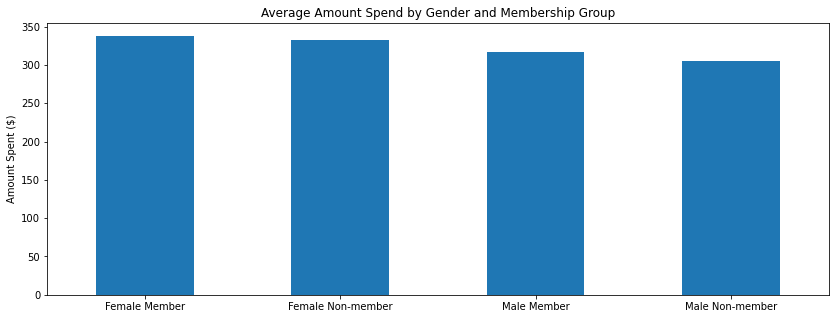

In [12]:
df = data.groupby(['gender', 'customer_type'])['total'].mean()
plt.figure(figsize=(14,5))
df.plot(kind = 'bar')
plt.ylabel('Amount Spent ($)')
plt.xlabel('')
plt.title('Average Amount Spend by Gender and Membership Group')
x_labels = ['Female Member', 'Female Non-member', 'Male Member', 'Male Non-member']
plt.xticks([0, 1, 2, 3], x_labels, rotation = 0)
plt.show()

Members generally spend slightly more than normal customers on average, however the difference in average spending is greater between males and females, as females spend \\$25 more than males on average. When we look at the combinations of gender and customer type, we can see that female members are the group that spend the most on average, with an average total of \\$337, compared to an average total of \\$305 for male non-members.

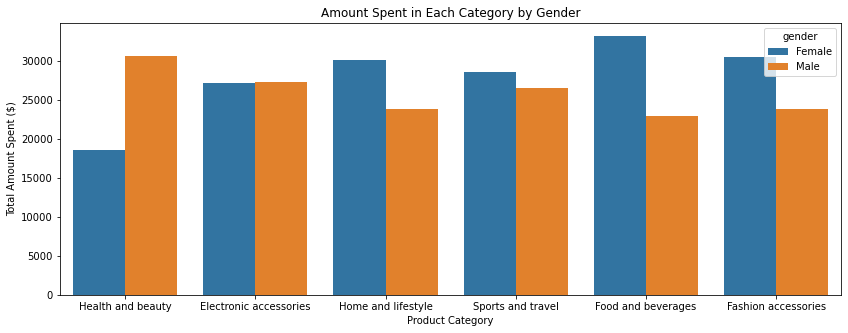

In [13]:
plt.figure(figsize=(14,5))
sns.barplot(x='product_line', y = 'total', hue = 'gender', data = data, estimator = sum, ci = None)
plt.xlabel('Product Category')
plt.ylabel('Total Amount Spent ($)')
plt.title('Amount Spent in Each Category by Gender')
plt.show()

The gender and product category responsible for the highest total amount spent is females for food and beverages with \\$33,170 spent. However, the male spending in food and beverages is the second to lowest category with only \\$22,900 spent.

The highest product category for males in terms of total amount spent was 'Health and beauty' at \\$30,600. However, females only spent \\$18,500 in 'Health and beauty'. This demonstrates that males and females have very different spending habits in terms of what they are purchasing.

## 2. Which product category generates the highest income?

In [14]:
query = """
SELECT 
    product_line,
    COUNT(*)
FROM sales
GROUP BY product_line
ORDER BY COUNT(*) DESC;
"""

#number of shopping runs in each general item categorization group
product_count = sql_to_pandas(query)
new_column_names = {'product_line': 'Product Line', 'COUNT(*)': 'Count'}
product_count.rename(columns=new_column_names)

,Product Line,Count
0,Fashion accessories,178
1,Food and beverages,174
2,Electronic accessories,170
3,Sports and travel,166
4,Home and lifestyle,160
5,Health and beauty,152


In [15]:
query = """
SELECT 
    product_line,
    AVG(total)
FROM sales
GROUP BY product_line
ORDER BY AVG(total) DESC;
"""

#average total amount spent by each of the product line categorizations
avg_product = sql_to_pandas(query)
new_column_names = {'product_line': 'Product Line', 'AVG(total)': 'Average Amount $'}
avg_product['AVG(total)'] = pd.to_numeric(avg_product['AVG(total)'])
avg_product.rename(columns=new_column_names).round(2)

,Product Line,Average Amount $
0,Home and lifestyle,336.64
1,Sports and travel,332.07
2,Health and beauty,323.64
3,Food and beverages,322.67
4,Electronic accessories,319.63
5,Fashion accessories,305.09


Most supermarket sales are categorized in the 'Fashion accessories' group with 178 purchases being categorized in this group. However, the fashion accessories category group has the smallest average total amount spent by customers out of all of the groups, which means that the supermarket is not making as much money off of these types of transactions (because cost of goods sold is constant for all items). So, while fasion accessories are the most common category for people to buy, the total purchase amount is generally the smallest.

In [16]:
query = """
SELECT 
    product_line,
    SUM(total)
FROM sales
GROUP BY product_line
ORDER BY SUM(total) DESC;
"""

#total amount spent in each of the product categories
total_product = sql_to_pandas(query)
new_column_names = {'product_line': 'Product Line', 'SUM(total)': 'Total $'}
total_product['SUM(total)'] = pd.to_numeric(total_product['SUM(total)'])
total_product.rename(columns=new_column_names).round(2)

,Product Line,Total $
0,Food and beverages,56144.84
1,Sports and travel,55122.83
2,Electronic accessories,54337.53
3,Fashion accessories,54305.90
4,Home and lifestyle,53861.91
5,Health and beauty,49193.74


Overall, 'Food and beverages' is the group of purchases that results in the highest overall total amount spent (and income). However, 'Home and lifestyle' shopping runs are associated with the highest average total price.

## 3. How is customer rating related to product category?

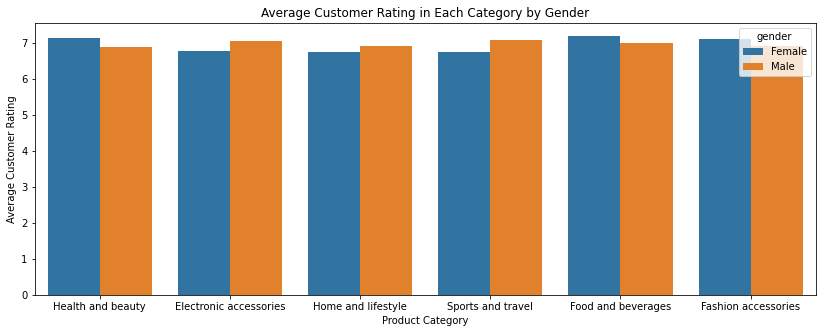

In [17]:
plt.figure(figsize=(14,5))
sns.barplot(x='product_line', y = 'rating', hue = 'gender', data = data, estimator = np.mean, ci = None)
plt.xlabel('Product Category')
plt.ylabel('Average Customer Rating')
plt.title('Average Customer Rating in Each Category by Gender')
plt.show()

There is no combination of gender and product category that greatly stands out from the others in terms of average rating. We do notice that the female categories have both the highest and lowest average ratings for the product categories.

## 4. What are trends or patterns regarding the location of the supercenters?

In [18]:
query = """
SELECT 
    city,
    COUNT(*)
FROM sales
GROUP BY city;
"""

#number of shopping runs at each of the 3 cities
city_count = sql_to_pandas(query)
new_column_names = {'city': 'City', 'COUNT(*)': 'Count'}
city_count.rename(columns = new_column_names)

,City,Count
0,Yangon,340
1,Naypyitaw,328
2,Mandalay,332


Since there are different numbers of observations in the dataset for the three locations of the supercenters, we will analyze the average of various metrics for the cities, rather than their totals.

In [19]:
#create a view with customer type as a binary variable
query = """
CREATE OR REPLACE VIEW member_one as
SELECT 
    invoice_id as id,
    case
        when customer_type = 'Member' then 1
        else 0
    end as member
FROM sales;
"""

cursor.execute(query)

In [20]:
#join this query with the view created in the previous code chunk
query = """
SELECT 
    city,
    AVG(member) * 100, 
    AVG(rating), 
    AVG(gross_income)
FROM sales
LEFT JOIN member_one ON member_one.id = sales.invoice_id
GROUP BY city
ORDER BY AVG(rating) DESC;
"""

#find average membership rates, rating, and gross income by each city
city_performance = sql_to_pandas(query)
# Convert the last three columns to numeric
last_three_columns = city_performance.columns[-3:]
city_performance[last_three_columns] = city_performance[last_three_columns].astype(float)
new_column_names = {'city': 'City', 'AVG(member) * 100': '% that are Members', 'AVG(rating)' : 'Average Rating',
                   'AVG(gross_income)' : 'Average Gross Income'}
city_performance.rename(columns=new_column_names).round(2)

,City,% that are Members,Average Rating,Average Gross Income
0,Naypyitaw,51.52,7.07,16.05
1,Yangon,49.12,7.03,14.87
2,Mandalay,49.70,6.82,15.23


The supercenter location in Naypyitaw is performing better that the other 2 locations in terms of percentage of purchases by members, average rating, and total gross income. 

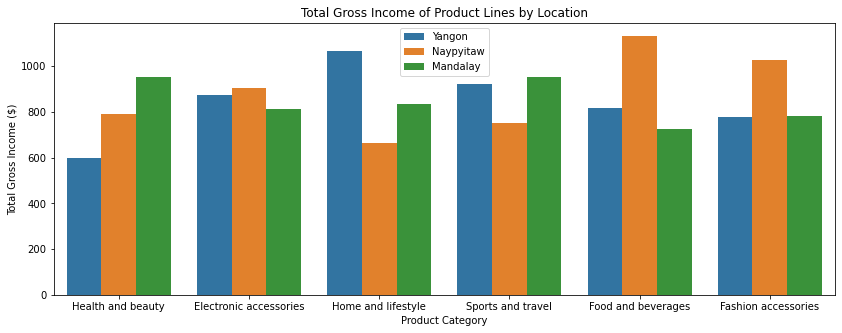

In [21]:
plt.figure(figsize=(14,5))
sns.barplot(x='product_line', y = 'gross_income', hue = 'city', data = data, estimator = sum, ci = None)
plt.xlabel('Product Category')
plt.title('Total Gross Income of Product Lines by Location')
plt.ylabel('Total Gross Income ($)')
plt.legend(loc = 'upper center')
plt.show()

The supercenter location in Naypyitaw has significantly higher gross incomes for Food and beverages and Fashion accessories comapred to the other locations. However, it's home and lifestyle section is lagging behind the other locations, which is an area to focus on.

## 5. What are trends that have occured over this three month period?

In [22]:
data['date'] = pd.to_datetime(data['date'])

# Set the "date" column as the DataFrame's index
data.set_index('date', inplace=True)

# Group the observations by week and sum up the values in the "total" column
df_weekly = data.resample('W').sum()

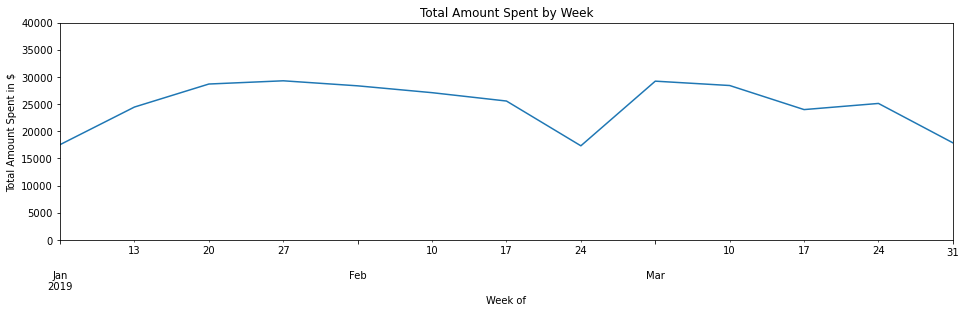

In [23]:
plt.figure(figsize=(16,4))
df_weekly['total'].plot(kind = 'line')
plt.ylim(0, 40000)
plt.xlabel('Week of')
plt.ylabel('Total Amount Spent in $')
plt.title('Total Amount Spent by Week')
plt.show()

There have been some weeks with significantly lower total sales in $, such as at the end of February and the end of March.

In [24]:
data.reset_index(inplace=True)
data.rename(columns={'index': 'date'}, inplace=True)

In [25]:
data['month'] = data['date'].dt.month

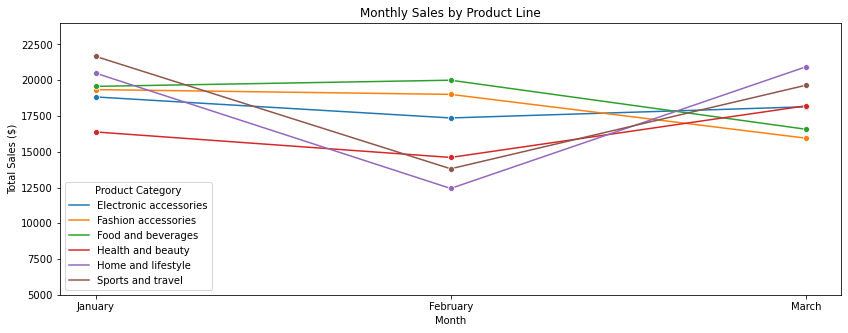

In [26]:
data_grouped = data.groupby(['product_line', 'month']).sum().reset_index()

plt.figure(figsize=(14, 5))
plt.ylim(5000, 24000)
x_labels = ['January', 'February', 'March']
plt.xticks([1, 2, 3], x_labels, rotation = 0)
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
sns.lineplot(data=data_grouped, x='month', y='total', hue='product_line', marker='o')
plt.legend(loc='lower left', title = "Product Category")
plt.title("Monthly Sales by Product Line")
plt.show()

February sales dropped significantly for 'Home and lifestyle' and 'Sports and travel' products.

## 6. Are there any patterns in the data related to time of day?

In [27]:
#change the time column to datetime column type
data['time'] = pd.to_datetime(data['time'])
#create an hour column using the hour from the time column
data['hour'] = data['time'].dt.hour

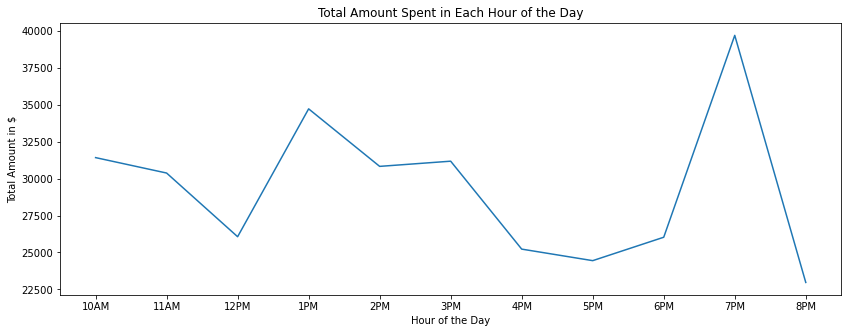

In [28]:
plt.figure(figsize=(14, 5))
data.groupby(data['hour'])["total"].sum().plot(kind="line", rot=25)
plt.title("Total Amount Spent in Each Hour of the Day")
plt.ylabel("Total Amount in $")
plt.xlabel('Hour of the Day')
x_labels = ['10AM', '11AM', '12PM', '1PM', '2PM',
           '3PM', '4PM', '5PM', '6PM', '7PM', '8PM']
plt.xticks([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], x_labels, rotation = 0)
plt.show()

The most sales in dollars occur at 7PM, but there is a sharp decline in the next hour at 8PM. Management could consider opening the stores earlier, as the sales at 10AM are still relatively high.

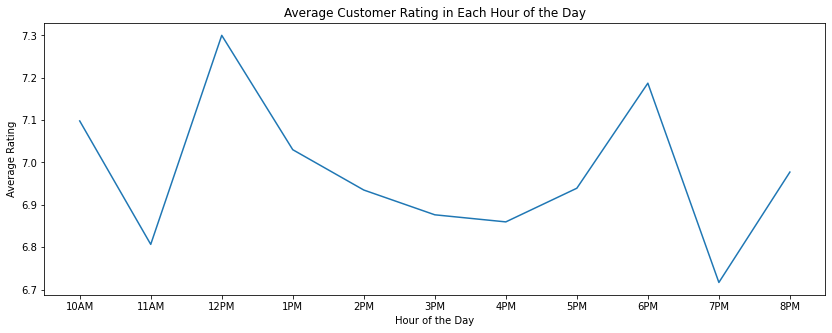

In [29]:
plt.figure(figsize=(14,5))
data.groupby(data['hour'])["rating"].mean().plot(kind="line", rot=25)
plt.ylabel("Average Rating")
plt.title("Average Customer Rating in Each Hour of the Day")
x_labels = ['10AM', '11AM', '12PM', '1PM', '2PM',
           '3PM', '4PM', '5PM', '6PM', '7PM', '8PM']
plt.xticks([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], x_labels, rotation = 0)
plt.xlabel('Hour of the Day')
plt.show()

Average ratings seem to drop mid-day, around 1 PM to 5 PM.

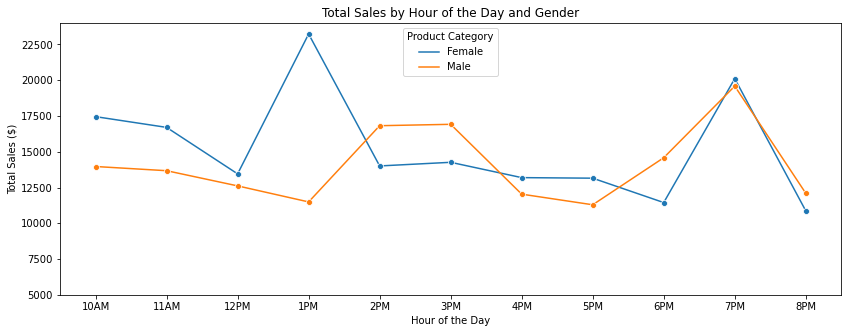

In [30]:
#group sales by hour of the day and gender
gender_time = data.groupby(['hour', 'gender']).sum().reset_index()

plt.figure(figsize=(14,5))
plt.ylim(5000, 24000)
x_labels = ['10AM', '11AM', '12PM', '1PM', '2PM',
           '3PM', '4PM', '5PM', '6PM', '7PM', '8PM']
plt.xticks([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], x_labels, rotation = 0)
plt.xlabel('Hour of the Day')
plt.ylabel('Total Sales ($)')
sns.lineplot(data=gender_time, x='hour', y='total', hue='gender', marker='o')
plt.legend(loc='upper center', title = "Product Category")
plt.title('Total Sales by Hour of the Day and Gender')
plt.show()

Female customers account for the majority of sales before 2PM.

## 7. What group types do the customers fall into?

In [31]:
query = """
SELECT
    gender,
    product_line,
    city,
    AVG(rating),
    COUNT(*)
FROM sales
GROUP BY
    gender,
    product_line,
    city
ORDER BY AVG(rating) DESC
LIMIT 5;
"""

#10 groups with highest average ratings
highest_ratings = sql_to_pandas(query)
new_column_names = {'AVG(rating)': 'Avg Rating', 'COUNT(*)': 'Count'}
highest_ratings['AVG(rating)'] = pd.to_numeric(highest_ratings['AVG(rating)'])
highest_ratings.rename(columns=new_column_names).round(2)

,gender,product_line,city,Avg Rating,Count
0,Female,Fashion accessories,Naypyitaw,7.61,35
1,Male,Sports and travel,Naypyitaw,7.47,16
2,Male,Electronic accessories,Yangon,7.44,32
3,Male,Food and beverages,Yangon,7.42,35
4,Male,Sports and travel,Yangon,7.35,30


In [32]:
query = """
SELECT
    gender,
    product_line,
    city,
    AVG(rating),
    COUNT(*)
FROM sales
GROUP BY
    gender,
    product_line,
    city
ORDER BY AVG(rating)
LIMIT 5;
"""

#10 groups with lowest average ratings
lowest_ratings = sql_to_pandas(query)
new_column_names = {'AVG(rating)': 'Avg Rating', 'COUNT(*)': 'Count'}
lowest_ratings['AVG(rating)'] = pd.to_numeric(lowest_ratings['AVG(rating)'])
lowest_ratings.rename(columns=new_column_names).round(2)

,gender,product_line,city,Avg Rating,Count
0,Female,Electronic accessories,Yangon,6.31,28
1,Female,Sports and travel,Mandalay,6.37,30
2,Male,Home and lifestyle,Mandalay,6.45,28
3,Male,Electronic accessories,Naypyitaw,6.54,27
4,Male,Food and beverages,Mandalay,6.54,21


There does not appear to be any patterns regarding the categories of customers with the highest and lowest average ratings.

# Customer Segmentation via Clustering

We will now perform a clustering algorithm on the dataset to identify different groups of customers at these supercenters, which may provide more insight into the types of customers that shop at the supercenters and what their spending habits and characteristics are. We may find many distinct different groups of customers, or we may find that customers are generally pretty similar and fall into only a couple of different clusters.

In [33]:
#create an array of the names of the columns of the categorical variables
categorical_cols = ['city', 'gender','product_line', 'customer_type', 'payment']

#create dataframe with the categorical variables one hot coded
encoded_df = pd.get_dummies(data, columns = categorical_cols)
encoded_df.head()

,date,invoice_id,branch,unit_price,quantity,tax_5_percent,total,time,cogs,gross_margin_percentage,...,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,customer_type_Member,customer_type_Normal,payment_Cash,payment_Credit card,payment_Ewallet
0,2019-01-05,750-67-8428,A,74.69,7,26.1415,548.9715,2023-07-17 13:08:00,522.83,4.761905,...,0,0,1,0,0,1,0,0,0,1
1,2019-03-08,226-31-3081,C,15.28,5,3.8200,80.2200,2023-07-17 10:29:00,76.40,4.761905,...,0,0,0,0,0,0,1,1,0,0
2,2019-03-03,631-41-3108,A,46.33,7,16.2155,340.5255,2023-07-17 13:23:00,324.31,4.761905,...,0,0,0,1,0,0,1,0,1,0
3,2019-01-27,123-19-1176,A,58.22,8,23.2880,489.0480,2023-07-17 20:33:00,465.76,4.761905,...,0,0,1,0,0,1,0,0,0,1
4,2019-02-08,373-73-7910,A,86.31,7,30.2085,634.3785,2023-07-17 10:37:00,604.17,4.761905,...,0,0,0,0,1,0,1,0,0,1


In [34]:
#drop the columns in the encoded dataframe that do not contribute to the k means clustering algorithm
#dropping a one hot encoded column is generally not necessary for k means clustering
encoded_df = encoded_df.drop(['invoice_id', 'branch', 'date', 'time', 'month', 'hour'], axis=1)
encoded_df.head()

,unit_price,quantity,tax_5_percent,total,cogs,gross_margin_percentage,gross_income,rating,city_Mandalay,city_Naypyitaw,...,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,customer_type_Member,customer_type_Normal,payment_Cash,payment_Credit card,payment_Ewallet
0,74.69,7,26.1415,548.9715,522.83,4.761905,26.1415,9.1,0,0,...,0,0,1,0,0,1,0,0,0,1
1,15.28,5,3.8200,80.2200,76.40,4.761905,3.8200,9.6,0,1,...,0,0,0,0,0,0,1,1,0,0
2,46.33,7,16.2155,340.5255,324.31,4.761905,16.2155,7.4,0,0,...,0,0,0,1,0,0,1,0,1,0
3,58.22,8,23.2880,489.0480,465.76,4.761905,23.2880,8.4,0,0,...,0,0,1,0,0,1,0,0,0,1
4,86.31,7,30.2085,634.3785,604.17,4.761905,30.2085,5.3,0,0,...,0,0,0,0,1,0,1,0,0,1


In [35]:
#scale all of the columns that were not one hot coded
numeric_df = encoded_df.iloc[:, 0:8]

#create an array of the column names
column_names = numeric_df.columns.values

#scale the dataframe so that the mean of each column is 0 and the variance is 1
#this improves the performance of the clustering algorithm to create different customer types
scaler = StandardScaler().fit(numeric_df.values)
features = scaler.transform(numeric_df.values)
scaled_features = pd.DataFrame(features, columns = column_names)
scaled_features.head()

,unit_price,quantity,tax_5_percent,total,cogs,gross_margin_percentage,gross_income,rating
0,0.718160,0.509930,0.919607,0.919607,0.919607,0.0,0.919607,1.238443
1,-1.525303,-0.174540,-0.987730,-0.987730,-0.987730,0.0,-0.987730,1.529527
2,-0.352781,0.509930,0.071446,0.071446,0.071446,0.0,0.071446,0.248760
3,0.096214,0.852165,0.675780,0.675780,0.675780,0.0,0.675780,0.830927
4,1.156959,0.509930,1.267125,1.267125,1.267125,0.0,1.267125,-0.973790


In [36]:
#take out the one hot coded columns
encoded_vars = encoded_df.iloc[:, 8:]
encoded_vars.head()

,city_Mandalay,city_Naypyitaw,city_Yangon,gender_Female,gender_Male,product_line_Electronic accessories,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,customer_type_Member,customer_type_Normal,payment_Cash,payment_Credit card,payment_Ewallet
0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1
1,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0
3,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1
4,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1


In [37]:
#join the scaled dataframe with the one hot coded dataframe
new_df = scaled_features.join(encoded_vars)
new_df.head()

,unit_price,quantity,tax_5_percent,total,cogs,gross_margin_percentage,gross_income,rating,city_Mandalay,city_Naypyitaw,...,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,customer_type_Member,customer_type_Normal,payment_Cash,payment_Credit card,payment_Ewallet
0,0.718160,0.509930,0.919607,0.919607,0.919607,0.0,0.919607,1.238443,0,0,...,0,0,1,0,0,1,0,0,0,1
1,-1.525303,-0.174540,-0.987730,-0.987730,-0.987730,0.0,-0.987730,1.529527,0,1,...,0,0,0,0,0,0,1,1,0,0
2,-0.352781,0.509930,0.071446,0.071446,0.071446,0.0,0.071446,0.248760,0,0,...,0,0,0,1,0,0,1,0,1,0
3,0.096214,0.852165,0.675780,0.675780,0.675780,0.0,0.675780,0.830927,0,0,...,0,0,1,0,0,1,0,0,0,1
4,1.156959,0.509930,1.267125,1.267125,1.267125,0.0,1.267125,-0.973790,0,0,...,0,0,0,0,1,0,1,0,0,1


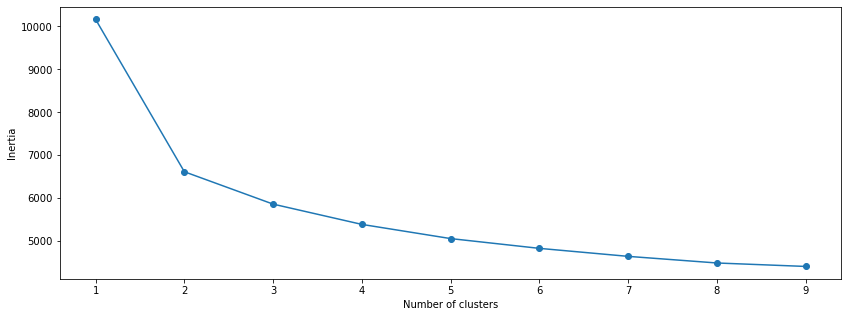

In [38]:
import random

#run the k means algorithm on the dataframe using clusters ranging from 1 to 10
SSE = []
for cluster in range(1,10):
    random.seed(15)
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(new_df)
    #save the inertia or SSE from each k means cluster to an array
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})

#plot the inertia values of SSE for each of different number of clusters
plt.figure(figsize=(14,5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Inertia measures how accurately the dataset was clustered by the K-Means clustering algorithm. Inertia is calculated by summing the squared distances of each point and its cluster centroid. So smaller intertia values are "better". If we see a large drop in the intertia value when we increase the number of clusters by 1, it suggests that the increase in the number of clusters is explaining the clusters in the data well.

The drop in the inertia value moving from 1 cluster to 2 clusters is very significant, but as the number of clusters increases from there, the drop in inertia is not as significant. This graph suggests that the optimal number of clusters to use is 2 clusters.

In [39]:
random.seed(15)
#cluster the data using 2 clusters
kmeans = KMeans(n_clusters = 2, init='k-means++')
kmeans.fit(new_df)

# Now, print the silhouette score of this model using 2 clusters

print(round(silhouette_score(new_df, kmeans.labels_, metric='euclidean'), 3))

0.301


Silhouette coefficients are a metric used to test the quality of the clusters, with values ranging from -1 to +1. Higher silhouette scores are better.

This model with 2 clusters has a silhouette coefficient of 0.3, which is a fairly high score.

### PCA

There are many features or columns in the dataset, so we will try Principal Component Analysis (PCA) to reduce the dimensions 
of the dataset and see if it improves the quality of our clusters.

To find the number of components we will use, we will find out of the number of components needed to reach a threshold of explained variance of 80%.

In [40]:
#create a PCA instance using 10 PCA components
pca = PCA(n_components=10)
#run the PCA algorithm on the dataframe
principalComponents = pca.fit_transform(new_df)

#create a dataframe of the 
PCA_components = pd.DataFrame(principalComponents)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
variance_df = pd.DataFrame({'Components':range(1,11), 'cumulative_variance':cumulative_variance})
variance_df

,Components,cumulative_variance
0,1,0.484422
1,2,0.583183
2,3,0.680846
3,4,0.732674
4,5,0.779996
5,6,0.814715
6,7,0.847900
7,8,0.879721
8,9,0.910394
9,10,0.927560


It takes 6 components to reach a cumulative sum of explained variance of 80%, so we will use 6 components.

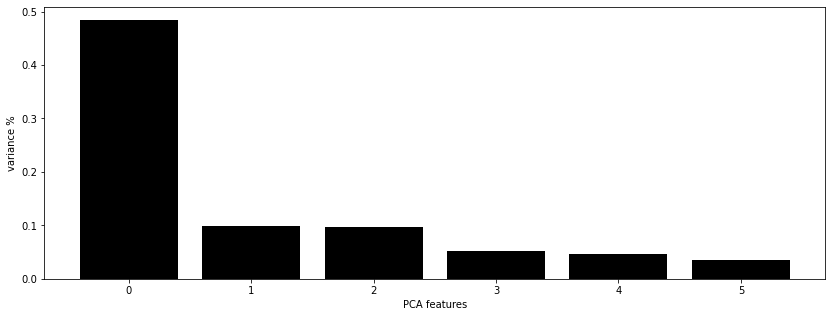

In [41]:
#create a PCA instance using 10 PCA components
pca = PCA(n_components=6)
#run the PCA algorithm on the dataframe
principalComponents = pca.fit_transform(new_df)

#create a dataframe of the 
PCA_components = pd.DataFrame(principalComponents)

features = range(pca.n_components_)

#plot the explained variance from each of the 6 PCA components
plt.figure(figsize=(14,5))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

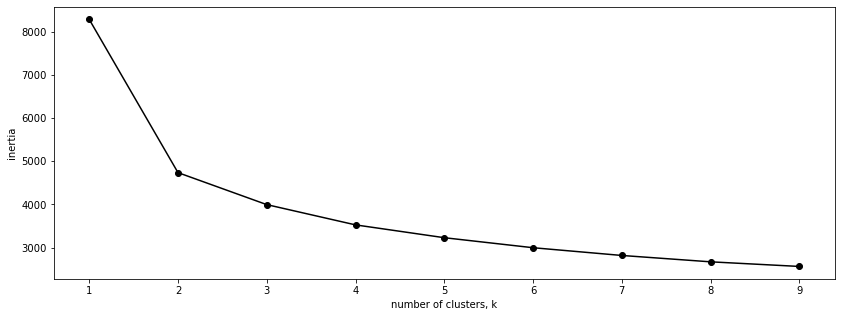

In [42]:
#create an array on different numbers of ks to use for the k means algorithm
ks = range(1, 10)
inertias = []

#find the inertia or SSE values using different numbers of ks in the k means algorithm on the PCA dataset
random.seed(15)
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components)
    inertias.append(model.inertia_)

plt.figure(figsize=(14,5))
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Based on this graph, it still looks like the ideal number of clusters is still 2.

In [43]:
random.seed(15)
model = KMeans(n_clusters=2)
model.fit(PCA_components.iloc[:,:6])

# silhouette score
print(round(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean'), 3))

0.514


Silhouette scores range from -1 to 1, where a high value indicates that a customer is well matched to their cluster.

The silhouette score of 0.51 is significantly higher than the previous score of 0.3, and this high score suggests that 2 clusters after using PCA is a good clustering solution.

### Cluster Analysis

In [44]:
#add the predicted cluster as a column in the dataset
random.seed(15)
pred = model.predict(PCA_components)

#add a column to the original dataframe showing which cluster they belong to
encoded_df['cluster'] = pred
#change 0s to 1s and 1s to 2s
encoded_df['cluster'] = encoded_df['cluster'].replace({0:1, 1:2})

In [45]:
#find the average of all the variable across each cluster
avg_df = encoded_df.groupby(['cluster']).mean()
avg_df

,unit_price,quantity,tax_5_percent,total,cogs,gross_margin_percentage,gross_income,rating,city_Mandalay,city_Naypyitaw,...,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,customer_type_Member,customer_type_Normal,payment_Cash,payment_Credit card,payment_Ewallet
cluster,,,,,,,,,,,,,,,,,,,,,
1,45.297447,4.325826,8.307023,174.447473,166.140450,4.761905,8.307023,7.000300,0.334835,0.315315,...,0.178679,0.181682,0.154655,0.159159,0.159159,0.492492,0.507508,0.345345,0.312312,0.342342
2,76.359371,7.871257,29.481713,619.115964,589.634251,4.761905,29.481713,6.917665,0.326347,0.353293,...,0.176647,0.158683,0.146707,0.161677,0.179641,0.517964,0.482036,0.341317,0.308383,0.350299


In [46]:
encoded_df.groupby(['cluster']).count().iloc[:,1]

cluster
1    666
2    334
Name: quantity, dtype: int64

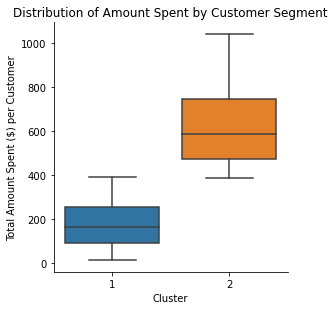

In [47]:
sns.catplot(x = 'cluster', y='total', kind='box',data=encoded_df, height=4)
plt.ylabel("Total Amount Spent ($) per Customer")
plt.xlabel('Cluster')
plt.title('Distribution of Amount Spent by Customer Segment')
plt.show()

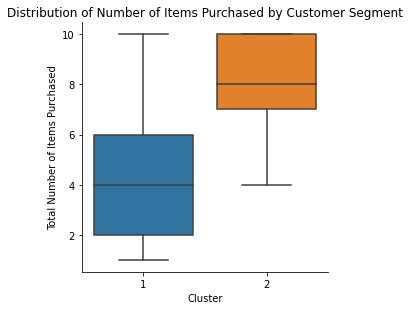

In [48]:
sns.catplot(x = 'cluster', y='quantity', kind='box',data=encoded_df, height = 4)
plt.ylabel("Total Number of Items Purchased")
plt.xlabel('Cluster')
plt.title('Distribution of Number of Items Purchased by Customer Segment')
plt.show()

In the dataframe above, we can see that the largest differences between the 2 clusters is their spending amounts, rather than the city, gender, product line, member type, or type of payment.

There are 666 customers in cluster 1 and 334 customers in cluster 2.

Cluster 1: Generally spends less overall, buys fewer items, and the items themselves are cheaper items.

Cluster 2: These people generally spend much more in total, buy more items, and the items are more expensive by the unit.

We can see that there are two very distinct groups of customers in terms of spending amounts and quantiy, based on the boxplots. There is no overlap in the boxplots between cluster 1 and 2 for both total amount spent and the number of items purchased in a shopping run. There are not significant differences in the location, product categories, or the payment or membership types on average between these customer segments.

### Using 4 Clusters

In [49]:
random.seed(15)
np.random.seed(15)
#run a k means clustering algorithm on the PCA dataset using 4 clusters
model = KMeans(n_clusters=4, random_state = 15)
model.fit(PCA_components)

#predict the cluster of each customer
pred = model.predict(PCA_components)

#add the cluster results to the dataframe
encoded_df['cluster'] = pred
encoded_df['cluster'] = encoded_df['cluster'].replace({0:1, 1:2, 2:3, 3:4})

#find the average value by each cluster
avg_df = encoded_df.groupby(['cluster']).mean()

#averages of the numeric columns
avg_df.iloc[:,:8].round(2)

,unit_price,quantity,tax_5_percent,total,cogs,gross_margin_percentage,gross_income,rating
cluster,,,,,,,,
1,84.26,8.72,36.36,763.49,727.13,4.76,36.36,6.62
2,68.37,2.30,7.75,162.78,155.03,4.76,7.75,6.80
3,25.21,5.13,6.23,130.88,124.65,4.76,6.23,7.14
4,62.02,6.93,20.20,424.24,404.04,4.76,20.20,7.16


In [50]:
#averages of the binary columns
avg_df.iloc[:,8:].round(2)

,city_Mandalay,city_Naypyitaw,city_Yangon,gender_Female,gender_Male,product_line_Electronic accessories,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,customer_type_Member,customer_type_Normal,payment_Cash,payment_Credit card,payment_Ewallet
cluster,,,,,,,,,,,,,,,,
1,0.34,0.37,0.29,0.52,0.48,0.19,0.17,0.15,0.15,0.17,0.16,0.52,0.48,0.36,0.34,0.30
2,0.35,0.30,0.35,0.39,0.61,0.14,0.22,0.18,0.15,0.16,0.16,0.50,0.50,0.35,0.31,0.33
3,0.32,0.33,0.36,0.54,0.46,0.20,0.16,0.17,0.16,0.16,0.16,0.50,0.50,0.33,0.32,0.35
4,0.32,0.33,0.35,0.55,0.45,0.15,0.17,0.19,0.15,0.15,0.18,0.49,0.51,0.34,0.28,0.38


In [51]:
#number of customers in each cluster
encoded_df.groupby(['cluster']).count().iloc[:,1]

cluster
1    165
2    248
3    315
4    272
Name: quantity, dtype: int64

When we cluster the customers into 4 different clusters, we see some interesting differences between the clusters.

Cluster 1: These customers generally spend the most in total, and the items they buy are the most expensive. These customers also generally buy the most items, so these customers are the type of customers that the supercenter makes the most money on. Unfortunately, there are only 165 customers in this category. One important thing to note is that these customers generally give the lowest ratings, which should be looked into if possible. The most common product line for this cluster is electronic accessories and most of them are members. Also, most of them are in Naypyitaw, which is a sign that that location is doing well.

Cluster 2: These customers generally buy fairly expensive items, but very few items (only 2.3 on average). They generally spend a small amount in total and 60% of these customers are male. The most common product line for this cluster is fashion accessories.

Cluster 3: These customers generally buy items that are very cheap by unit, and their purchases are generally the lowest in total out of all the clusters. This cluster has a high average rating and the most common product line for this cluster is electronic accessories.

Cluster 4: These customers generally spend a fair amount in total, products of medium unit price, and a relatively high number of total items. The most common product line for this cluster is food and beverages and sports.

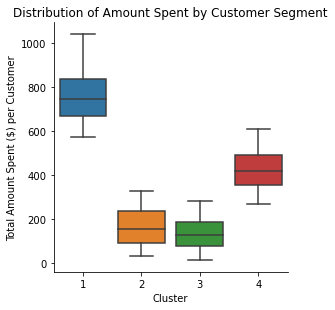

In [52]:
sns.catplot(x = 'cluster', y='total', kind='box',data=encoded_df, height = 4)
plt.ylabel("Total Amount Spent ($) per Customer")
plt.xlabel('Cluster')
plt.title('Distribution of Amount Spent by Customer Segment')
plt.show()

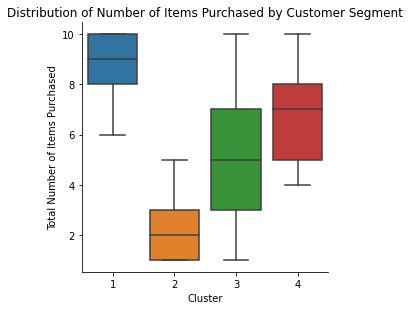

In [53]:
sns.catplot(x = 'cluster', y='quantity', kind='box',data=encoded_df, height = 4)
plt.ylabel("Total Number of Items Purchased")
plt.xlabel('Cluster')
plt.title('Distribution of Number of Items Purchased by Customer Segment')
plt.show()

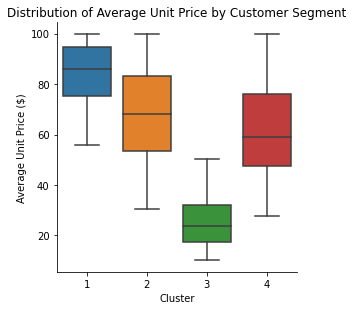

In [54]:
sns.catplot(x = 'cluster', y='unit_price', kind='box',data=encoded_df, height = 4)
plt.ylabel("Average Unit Price ($)")
plt.xlabel('Cluster')
plt.title('Distribution of Average Unit Price by Customer Segment')
plt.show()

Although the interia or sum of squared error graph did not suggest that we should use 4 clusters, clustering the customers into 4 segments provided us with more insight into the types of customers at the supercenter than using 2 clusters did.